In [5]:
import os, sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
#from skimage import tifffile
import time
import glob, os
import scipy.stats as stats
import pandas as pd
import dask.array as da
from scipy.signal import find_peaks
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [236]:
def dff(data, window, percentile, downsample=1):
    """
    Estimate delta-f / f_baseline with the option to downsample
    
    data : 1D numpy array
        Data to be processed
        
    window : int
        Window size for baseline estimation. If downsampling is used, window will shrink proportionally
        
    percentile : int
        Percentile used as baseline
    
    downsample : int
        Rate of downsampling used before estimating baseline. For no downsampling, use downsample=1.
    """
    
    from scipy.signal import decimate
    from scipy.ndimage.filters import percentile_filter
    from numpy import interp
    
    if downsample == 1:
        baseline = percentile_filter(data, percentile=percentile, size=window)
    else:
        data_ds = decimate(data, downsample, ftype='iir', zero_phase=True)
        # using decimate with the default filter shifts the output by ~1-2% relative to the input. 
        # correct for baseline shift by adding a small constant to data_ds
        data_ds += data.min() - data_ds.min()
        baseline_ds = percentile_filter(data_ds, percentile=percentile, size=window//downsample)
        
        baseline = interp(range(0, len(data)), range(0, len(data), downsample), baseline_ds)
    
    return (data - baseline) / baseline

In [237]:
ephysDirs = [r'E:\ketamine_paper\seg\20230701_f1\outs\swimRegressor_pre.npy',
                r'E:\ketamine_paper\seg\20230701_f2\outs\swimRegressor_pre.npy',
                r'E:\ketamine_paper\seg\20230702_f1_ket\outs\swimRegressor_pre.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f1_20230828_092539\outs\swimRegressor_pre.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f2_20230828_103034\outs\swimRegressor_pre.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f3_20230828_161001\outs\swimRegressor_pre.npy',]

gliaDirs = [r'E:\ketamine_paper\seg\20230701_f1\seg_red\glia_ca_pre.npy',
                r'E:\ketamine_paper\seg\20230701_f2\seg_red\glia_ca_pre.npy',
                r'E:\ketamine_paper\seg\20230702_f1_ket\01_preket_20230702_104443\red\seg\glia_dff.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f1_20230828_092539\red\seg\glia_ca_dff.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f2_20230828_103034\red\seg\glia_ca_dff.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f3_20230828_161001\red\seg\glia_ca_dff.npy']

stimDir = [r'E:\ketamine_paper\seg\20230701_f1\outs\stimInd_pre.npy',
                r'E:\ketamine_paper\seg\20230701_f2\outs\stimInd_pre.npy',
                r'E:\ketamine_paper\seg\20230702_f1_ket\outs\stimInd_pre.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f1_20230828_092539\outs\stimInd_pre.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f2_20230828_103034\outs\stimInd_pre.npy',
                r'E:\ketamine_paper\seg\20230826_ket_pre\f3_20230828_161001\outs\stimInd_pre.npy',]



In [238]:
allStrugInds = []
allCa = []
allStim = []
for i in range(len(gliaDirs)):
    caFish = np.load(gliaDirs[i],allow_pickle=True)
    caFish = caFish
    #caFish = dff(caFish,50,20)
    stimFish = np.load(stimDir[i],allow_pickle=True)
    strugFish = np.load(ephysDirs[i],allow_pickle=True)
    print(len(strugFish))
    print(len(stimFish))
    strugFish = (strugFish) / np.std(strugFish)
    allStrugInds.append(strugFish)
    allCa.append(caFish)
    allStim.append(stimFish)

1709
1709
1706
1706
1926
1926
1783
1783
1624
1624
1760
1760


In [239]:
np.shape(stimFish[0:len(allStim[i-2])])

(1760,)

In [240]:
for i in range(len(allStim)):
    allStim[i][np.where(allStim[i] < 0.001)] = 1
    allStim[i][np.where(allStim[i] < 1)] = 0

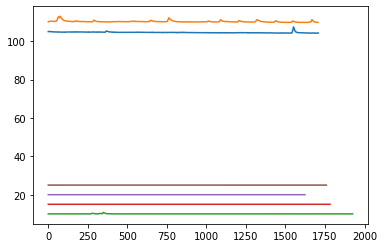

In [241]:
plt.figure()
for i in range(len(allCa)):
    plt.plot(allCa[i]+5*i)

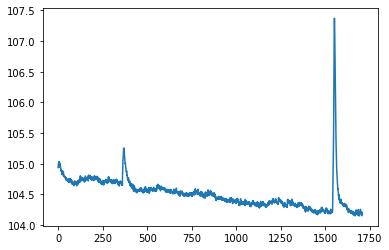

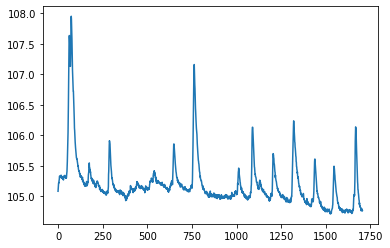

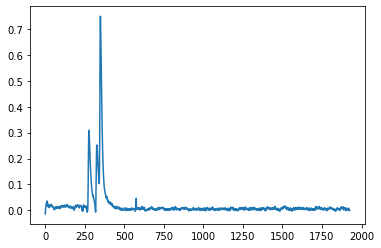

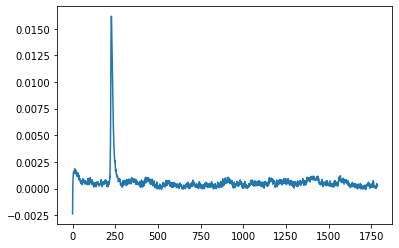

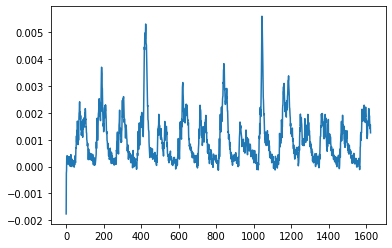

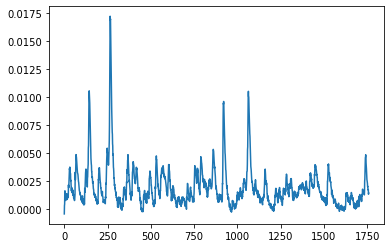

In [245]:

for i in range(len(allCa)):
    plt.figure()
    #plt.plot(allStrugInds[i])
    plt.plot(allCa[i])

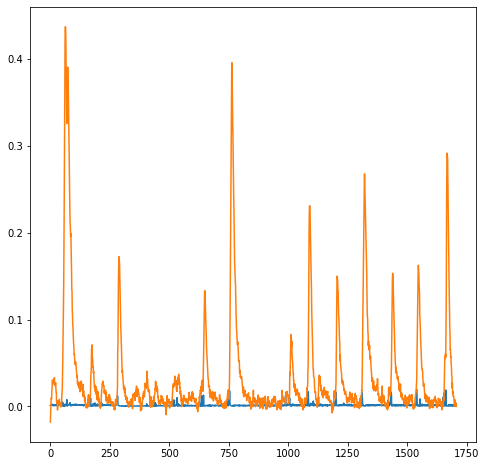

In [195]:
sampleswim = allStrugInds[1]
sampleCa = dff((allCa[1]-100),window = 50,percentile = 10)
plt.figure(figsize=(8,8)) 
plt.plot(sampleswim/500)
plt.plot(sampleCa)
#plt.savefig(r'Z:\Alex\preswimca.svg',dpi=300)

In [196]:
def design_mat(swims,kernel_size,y):
    x = np.zeros([len(y),kernel_size])
    
    for i in range(len(y)):
        x[i,:] = swims[i:i+kernel_size]
        
    return x
def fitCa(x_total, ca):
    
    
    xTx = np.matmul(np.transpose(x_total),x_total)
    inv_x = np.linalg.pinv(xTx)
    beta = np.matmul(inv_x,np.matmul(np.transpose(x_total),ca))
    
    return beta

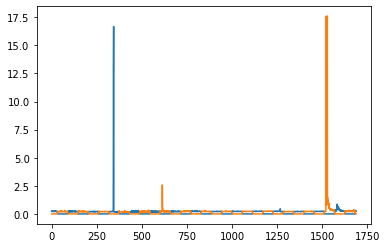

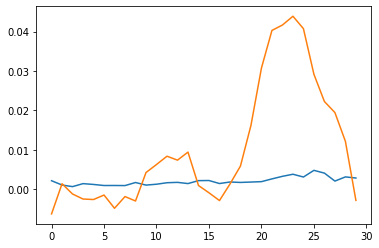

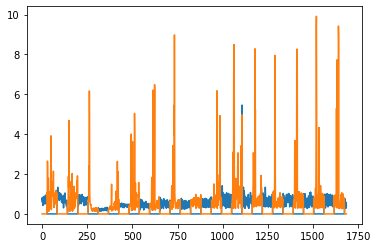

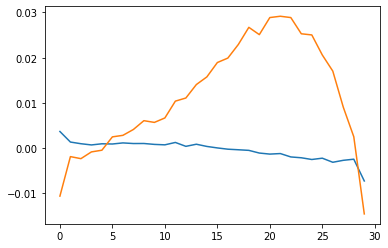

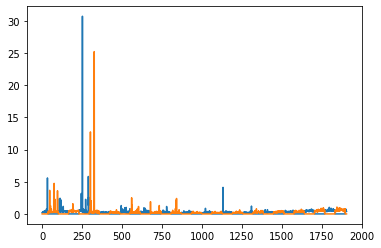

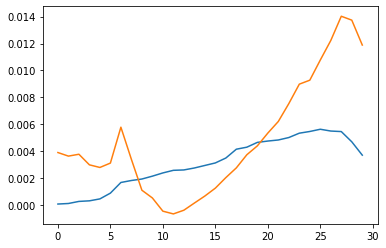

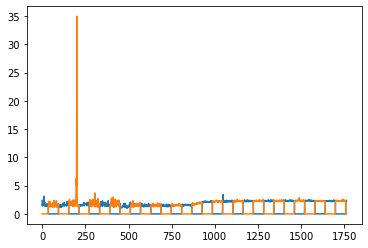

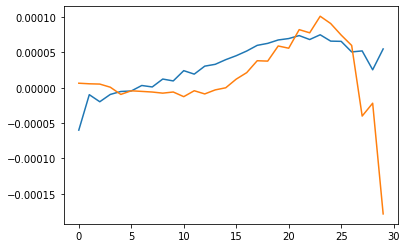

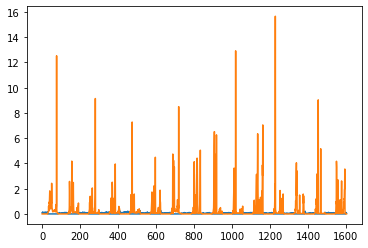

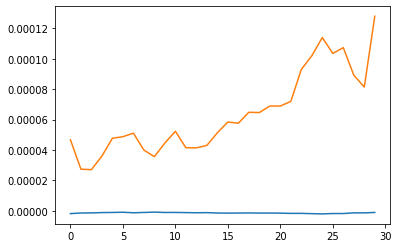

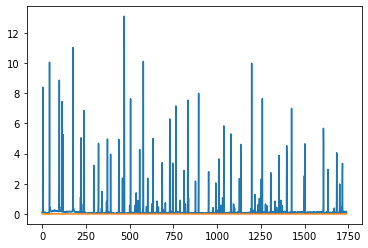

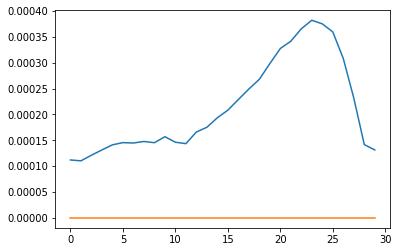

In [197]:
for i in range(len(allStim)):
    tstart = 50
    kernel_size = 30
    all_swims = allStrugInds[i]
    cl = 1 - allStim[i]
    ol = allStim[i]
    all_cl_swims = np.multiply(cl,all_swims)
    all_ol_swims = np.multiply(ol,all_swims)
    intSwims = all_swims[(tstart - kernel_size):]
    cl_swims = all_cl_swims[(tstart - kernel_size):]
    ol_swims = all_ol_swims[(tstart - kernel_size):]
    plt.figure()
    plt.plot(cl_swims)
    plt.plot(ol_swims)
    ca = allCa[i][tstart:]


    x_swim = design_mat(intSwims,kernel_size,ca)
    x_ol= design_mat(ol_swims,kernel_size,ca)
    #x_ar = design_mat(autoR,ar_kernel_size,ca)
    constant = np.ones([len(ca),1])
    x_total1 = np.hstack([constant,x_ol])

    beta_total1 = fitCa(x_total1,ca)
    beta_c = beta_total1[0]
    beta_ol = beta_total1[1:(len(x_ol[0])+1)]
    cahat1 = np.matmul(x_total1,beta_total1)
    residual = ca - cahat1

    x_total2 = np.hstack([constant,x_swim])
    beta_total2 = fitCa(x_total2,residual)
    beta_c = beta_total2[0]
    beta_swim = beta_total2[1:(len(x_swim[0])+1)]
    fast_kernel = beta_swim
    slow_kernel = beta_ol
            #plt.plot(beta_swim)
    #     mean_fast_kernel = np.mean(fast_kernels,axis = 0)
    #     std_fast_kernel = np.std(fast_kernels,axis=0)
    #     mean_slow_kernel = np.mean(slow_kernels,axis = 0)
    #     std_slow_kernel = np.std(slow_kernels,axis = 0)
    #     fps = 20
    #     plt.rcParams['axes.linewidth'] = 2
    #     plt.rcParams['xtick.major.size'] = 7
    #     plt.rcParams['ytick.major.size'] = 7
    #     plt.rcParams['xtick.major.width'] = 2
    #     plt.rcParams['ytick.major.width'] = 2
    #     plt.subplot(3,6,j+1)
    #     #plt.tight_layout()
    #     #plt.subplots_adjust(left = 0.15)
    #     plt.plot(np.linspace(-1 * fast_kernel_size/fps, 0, fast_kernel_size), mean_fast_kernel)
    #     plt.fill_between(np.linspace(-1 * fast_kernel_size/fps, 0, fast_kernel_size),mean_fast_kernel - std_fast_kernel, mean_fast_kernel + std_fast_kernel,alpha = 0.2)
    #     plt.plot(np.linspace(-1 * slow_kernel_size/fps, 0, slow_kernel_size), mean_slow_kernel,color = 'red')
    #     plt.fill_between(np.linspace(-1 * slow_kernel_size/fps, 0, slow_kernel_size),mean_slow_kernel - std_slow_kernel, mean_slow_kernel + std_slow_kernel,alpha = 0.2,facecolor = 'red')
    #     plt.plot(np.linspace(-20,0,100),np.zeros([100,1]),'--', color = 'black')
    #     plt.xticks([-12,-9,-6,-3,0],fontsize = 16)
    #     plt.yticks(fontsize = 16)
    #     plt.xlim(-12,0)
    #     #plt.xlabel('seconds before swim onset',fontsize = 20)
    #     #plt.ylabel('coefficient',fontsize =20)
    #     plt.legend(['closed loop swims','open loop swims'],loc = 'lower left',fontsize = 12)
    #     plt.title('roi ' + str(j))
    #     ax = plt.gca()
    #     ax.linewidth = 3
    # #plt.savefig(r'Z:\Alex\figs\all_kernels_fish' + expt + '.png',dpi = 300)
    #     all_fast_kernels.append(fast_kernels)
    #     all_slow_kernels.append(slow_kernels)
    # plt.show()

    plt.figure()
    plt.plot(fast_kernel)
    plt.plot(slow_kernel)

In [203]:
struggleThresh = [1,1.2,1,3,1,0.6]

In [204]:
from scipy.signal import find_peaks

In [205]:
strugs = []
for i in range(len(allStrugInds)):
    swims = allStrugInds[i]
    swims[2] = 10
    swims[-2] = 10
    strug = find_peaks(swims,height = struggleThresh[i])[0]
    #strug = strug[strug < (len(allCa[i]) - 30)]
    strugs.append(strug)
    

In [206]:
#np.save(r'Z:\Marc\strugs_pre.npy',strugs)

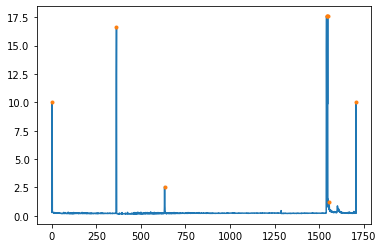

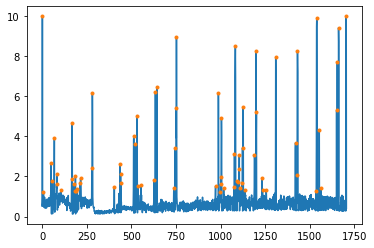

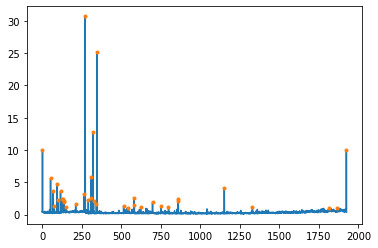

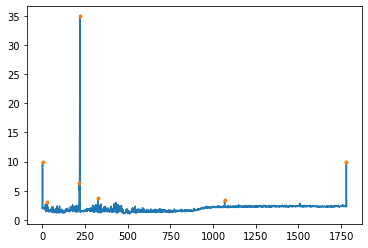

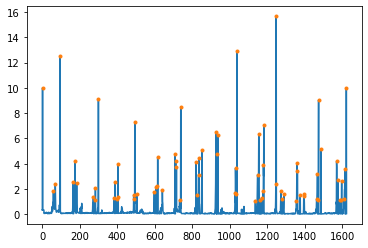

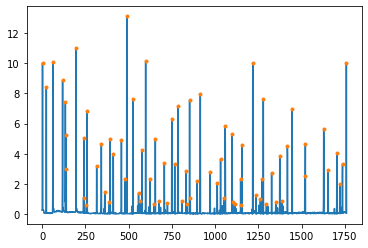

In [207]:
for i in range(len(allStrugInds)):
    plt.figure()
    plt.plot(allStrugInds[i])
    plt.plot(strugs[i],allStrugInds[i][strugs[i]],'.')

In [208]:
frac_passives = np.zeros([len(strugs),])
for i in range(len(strugs)):
    isi = np.diff(strugs[i])
    isi = isi[isi > 10]
    frac_passives[i] = np.sum(isi)/len(allStrugInds[i])

In [209]:
frac_passives

array([0.99122294, 0.87280188, 0.9761163 , 0.99551318, 0.8546798 ,
       0.95113636])

In [697]:
strugTrig_pre = np.zeros([len(allCa)])
fishStrugAvg_pre = np.zeros([6,30])
for i in range(len(strugs)):
    dfs = np.zeros([len(strugs[i]),])
    catrace = allCa[i]
    fishStrugs = np.zeros([len(strugs[i]),30])
    for j in range(len(strugs[i])):
        if (i == 0):
            strugInd = strugs[i][j]
            preInd = strugInd - 15
            postInd = strugInd + 15
            fishStrugs[j] = catrace[preInd:postInd] - catrace[(preInd+10)]
            dfs[j] = np.sum(fishStrugs[j][10:])
            
        elif (i == 2):
            strugInd = strugs[i][j]
            preInd = strugInd - 14
            postInd = strugInd + 16
            fishStrugs[j] = catrace[preInd:postInd] - catrace[(preInd+10)]
            dfs[j] = np.sum(fishStrugs[j][10:])
            
        else:
            strugInd = strugs[i][j]
            preInd = strugInd - 10
            postInd = strugInd + 20
            fishStrugs[j] = catrace[preInd:postInd] - catrace[(preInd+10)]
            dfs[j] = np.sum(fishStrugs[j][10:])
           
        #print(dfs)
    fishStrugAvg_pre[i] = np.nanmean(fishStrugs,axis=0)
    strugTrig_pre[i] = np.nanmean(dfs)

In [698]:
strugTrig_pre

array([ 46.70614759,  14.2195102 , 149.68146959,  52.4522218 ,
        -0.65833784,  13.75665928])

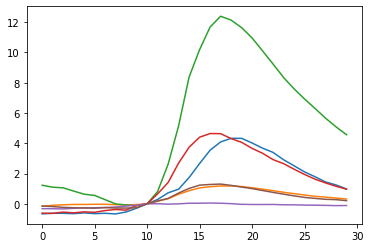

In [699]:
plt.figure()
plt.plot(fishStrugAvg_pre.T)

In [420]:
np.savetxt(r'Z:\Marc\motorclamp_pre_trace.csv',fishStrugAvg_pre.T,delimiter = ",")
np.savetxt(r'Z:\Marc\motorclamp_pre_mag.csv',strugTrig_pre,delimiter = ",")

In [246]:
ephysDirs = [r'E:\ketamine_paper\seg\20230701_f1\outs\swimRegressor_post.npy',
                r'E:\ketamine_paper\seg\20230701_f2\outs\swimRegressor_post.npy',
                r'E:\ketamine_paper\seg\20230702_f1_ket\outs\swimRegressor_post.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f2_20230828_120947\outs\swimRegressor_post.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f3_20230828_143104\outs\swimRegressor_post.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f4_20230828_152217\outs\swimRegressor_post.npy',]

gliaDirs = [r'E:\ketamine_paper\seg\20230701_f1\seg_red\glia_ca_post.npy',
                r'E:\ketamine_paper\seg\20230701_f2\seg_red\glia_ca_post.npy',
                r'E:\ketamine_paper\seg\20230702_f1_ket\03_postket_20230702_135132\red\seg\glia_dff.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f2_20230828_120947\red\seg\glia_ca_dff.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f3_20230828_143104\red\seg\glia_ca_dff.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f4_20230828_152217\red\seg\glia_ca_dff.npy']
stimDirs = [r'E:\ketamine_paper\seg\20230701_f1\outs\stimInd_post.npy',
                r'E:\ketamine_paper\seg\20230701_f2\outs\stimInd_post.npy',
                r'E:\ketamine_paper\seg\20230702_f1_ket\outs\stimInd_post.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f2_20230828_120947\outs\stimInd_post.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f3_20230828_143104\outs\stimInd_post.npy',
                r'E:\ketamine_paper\seg\20230826_ket_post\f4_20230828_152217\outs\stimInd_post.npy',]



In [247]:
allStrugInds = []
allCa = []
allStim=[]
for i in range(len(gliaDirs)):
    caFish = np.load(gliaDirs[i],allow_pickle=True)
    #caFish = dff(caFish,20,50)
    stimFish = np.load(stimDirs[i],allow_pickle=True)
    caFish = caFish
    strugFish = np.load(ephysDirs[i],allow_pickle=True)
    strugFish = (strugFish - np.mean(strugFish))/np.std(strugFish)
    allStrugInds.append(strugFish)
    allCa.append(caFish)
    allStim.append(stimFish)
for i in range(len(allStim)):
    allStim[i][np.where(allStim[i] < 0.001)] = 1
    allStim[i][np.where(allStim[i] < 1)] = 0

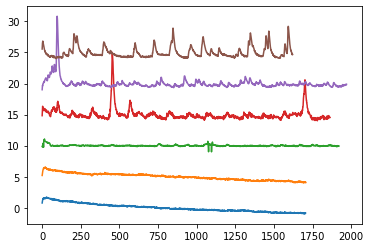

In [248]:
plt.figure()
for i in range(len(allCa)):
    plt.plot(((allCa[i] - np.mean(allCa[i]))/(np.mean(allCa[i])-np.min(allCa[i]))) + 5 * i)

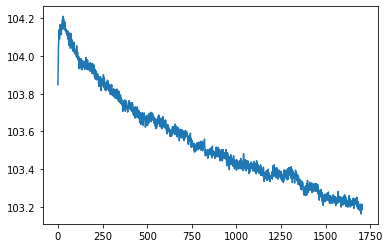

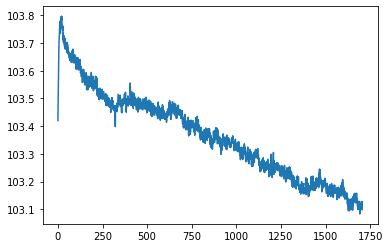

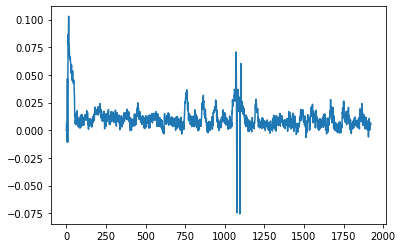

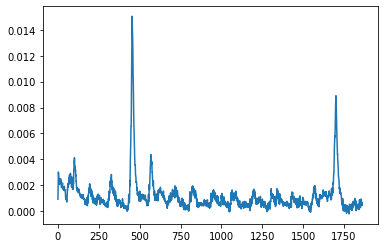

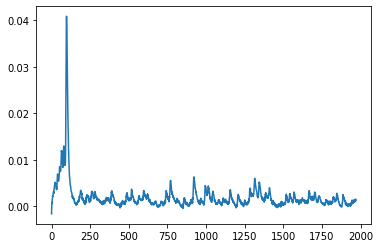

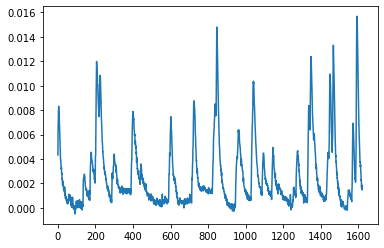

In [249]:
for i in range(len(allCa)):
    plt.figure()
    #plt.plot(allStrugInds[i])
    plt.plot(allCa[i])

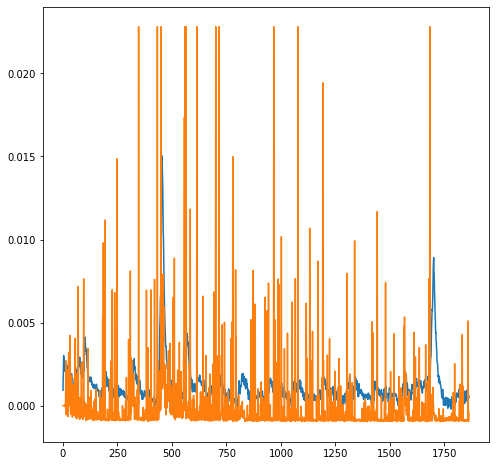

In [218]:
sampleswimpost =allStrugInds[3]
sampleswimpost = sampleswimpost / np.std(sampleswimpost)
samplecapost = allCa[3]
#samplecapost = dff(allCa[3],window=100,percentile=5)
#samplecapost = samplecapost / np.std(samplecapost)
plt.figure(figsize=(8,8))
plt.plot(samplecapost)
plt.plot(sampleswimpost/400)
plt.savefig(r'Z:\Alex\postswimca2.svg',dpi=300)

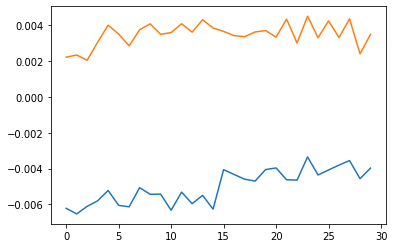

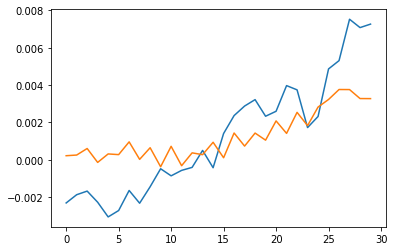

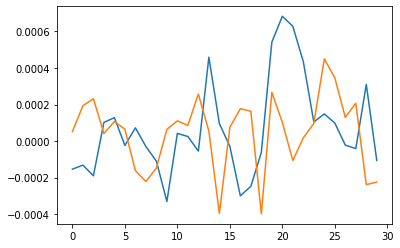

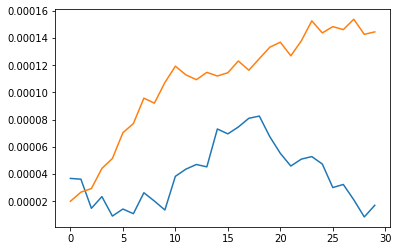

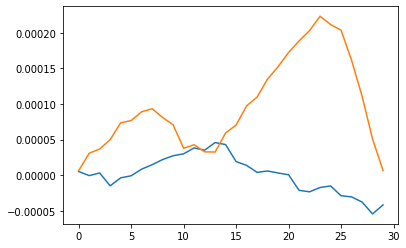

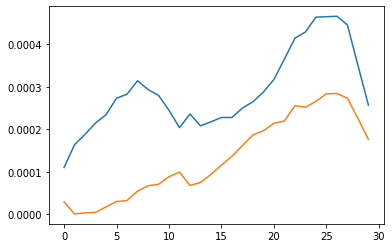

In [219]:
for i in range(len(allStim)):
    tstart = 50
    kernel_size = 30
    all_swims = allStrugInds[i]
    cl = 1 - allStim[i]
    ol = allStim[i]
    all_cl_swims = np.multiply(cl,all_swims)
    all_ol_swims = np.multiply(ol,all_swims)
    intSwims = all_swims[(tstart - kernel_size):]
    cl_swims = all_cl_swims[(tstart - kernel_size):]
    ol_swims = all_ol_swims[(tstart - kernel_size):]
    
    ca = allCa[i][tstart:]
 

    x_swim = design_mat(cl_swims,kernel_size,ca)
    x_ol= design_mat(ol_swims,kernel_size,ca)
    #x_ar = design_mat(autoR,ar_kernel_size,ca)
    constant = np.ones([len(ca),1])
    x_total1 = np.hstack([constant,x_ol])

    beta_total1 = fitCa(x_total1,ca)
    beta_c = beta_total1[0]
    beta_ol = beta_total1[1:(len(x_ol[0])+1)]
    cahat1 = np.matmul(x_total1,beta_total1)
    residual = ca - cahat1

    x_total2 = np.hstack([constant,x_swim])
    beta_total2 = fitCa(x_total2,residual)
    beta_c = beta_total2[0]
    beta_swim = beta_total2[1:(len(x_swim[0])+1)]
    fast_kernel = beta_swim
    slow_kernel = beta_ol
            #plt.plot(beta_swim)
    #     mean_fast_kernel = np.mean(fast_kernels,axis = 0)
    #     std_fast_kernel = np.std(fast_kernels,axis=0)
    #     mean_slow_kernel = np.mean(slow_kernels,axis = 0)
    #     std_slow_kernel = np.std(slow_kernels,axis = 0)
    #     fps = 20
    #     plt.rcParams['axes.linewidth'] = 2
    #     plt.rcParams['xtick.major.size'] = 7
    #     plt.rcParams['ytick.major.size'] = 7
    #     plt.rcParams['xtick.major.width'] = 2
    #     plt.rcParams['ytick.major.width'] = 2
    #     plt.subplot(3,6,j+1)
    #     #plt.tight_layout()
    #     #plt.subplots_adjust(left = 0.15)
    #     plt.plot(np.linspace(-1 * fast_kernel_size/fps, 0, fast_kernel_size), mean_fast_kernel)
    #     plt.fill_between(np.linspace(-1 * fast_kernel_size/fps, 0, fast_kernel_size),mean_fast_kernel - std_fast_kernel, mean_fast_kernel + std_fast_kernel,alpha = 0.2)
    #     plt.plot(np.linspace(-1 * slow_kernel_size/fps, 0, slow_kernel_size), mean_slow_kernel,color = 'red')
    #     plt.fill_between(np.linspace(-1 * slow_kernel_size/fps, 0, slow_kernel_size),mean_slow_kernel - std_slow_kernel, mean_slow_kernel + std_slow_kernel,alpha = 0.2,facecolor = 'red')
    #     plt.plot(np.linspace(-20,0,100),np.zeros([100,1]),'--', color = 'black')
    #     plt.xticks([-12,-9,-6,-3,0],fontsize = 16)
    #     plt.yticks(fontsize = 16)
    #     plt.xlim(-12,0)
    #     #plt.xlabel('seconds before swim onset',fontsize = 20)
    #     #plt.ylabel('coefficient',fontsize =20)
    #     plt.legend(['closed loop swims','open loop swims'],loc = 'lower left',fontsize = 12)
    #     plt.title('roi ' + str(j))
    #     ax = plt.gca()
    #     ax.linewidth = 3
    # #plt.savefig(r'Z:\Alex\figs\all_kernels_fish' + expt + '.png',dpi = 300)
    #     all_fast_kernels.append(fast_kernels)
    #     all_slow_kernels.append(slow_kernels)
    # plt.show()

    plt.figure()
    plt.plot(fast_kernel)
    plt.plot(slow_kernel)

In [231]:
struggleThresh = [0.4,0.1,0.5,0.1,0.2,0.1]

In [232]:
strugs = []
for i in range(len(allStrugInds)):
    swims = allStrugInds[i]
    swims[2] = 2
    swims[-2] = 2
    strug = find_peaks(swims,height = struggleThresh[i])[0]
    #strug = strug[strug < (len(allCa[i]) - 30)]
    strugs.append(strug)
    

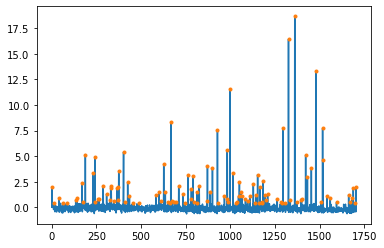

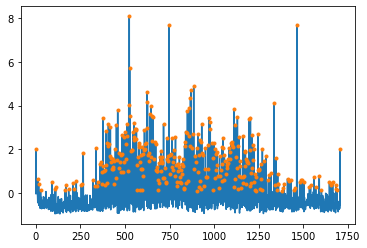

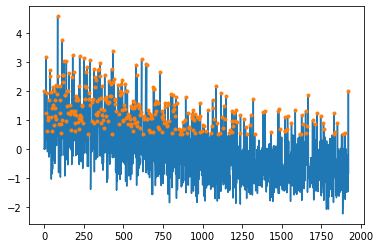

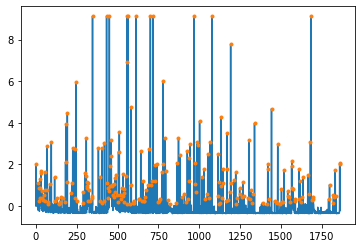

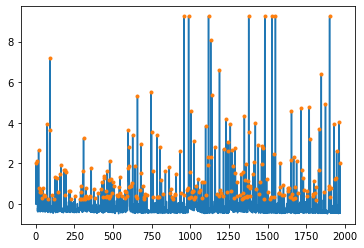

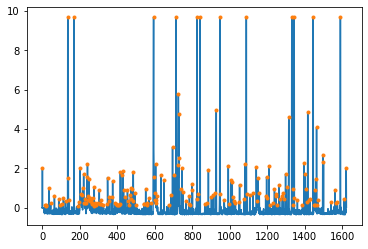

In [233]:
for i in range(len(allStrugInds)):
    plt.figure()
    plt.plot(allStrugInds[i])
    plt.plot(strugs[i],allStrugInds[i][strugs[i]],'.')

In [234]:
frac_passives = np.zeros([len(strugs),])
for i in range(len(strugs)):
    isi = np.diff(strugs[i])
    isi = isi[isi > 10]
    frac_passives[i] = np.sum(isi)/len(allStrugInds[i])

In [235]:
frac_passives

array([0.82180539, 0.36438196, 0.39646202, 0.53730542, 0.46423135,
       0.5918619 ])

In [165]:
strugTrig_post = np.zeros([len(allCa)])
fishStrugAvg_post = np.zeros([6,30])
for i in range(len(strugs)):
    dfs = np.zeros([len(strugs[i]),])
    catrace = allCa[i]
    fishStrugs = np.zeros([len(strugs[i]),30])
    for j in range(len(strugs[i])):
        if(i==3):
            strugInd = strugs[i][j]
            preInd = strugInd - 15
            postInd = strugInd + 15
            fishStrugs[j] = catrace[preInd:postInd] - catrace[(preInd+10)]
            dfs[j] = np.sum(fishStrugs[j][10:])
        else:
            strugInd = strugs[i][j]
            preInd = strugInd - 10
            postInd = strugInd + 20
            fishStrugs[j] = catrace[preInd:postInd] - catrace[(preInd+10)]
            dfs[j] = np.sum(fishStrugs[j][10:])
        #print(dfs)
    fishStrugAvg_post[i] = np.nanmean(fishStrugs,axis=0)
    strugTrig_post[i] = np.nanmean(dfs)

ValueError: could not broadcast input array from shape (27) into shape (30)

In [716]:
np.save(r'Z:\Marc\strugs_post.npy',strugs)

In [ ]:
strugTrig_post

In [ ]:
strugTrig_pre

In [ ]:
plt.figure()
plt.plot(fishStrugAvg_post.T)
plt.ylim(ymax = 12)

In [ ]:
fishSummary = {}
fishSummary['id'] = []
fishSummary['ca'] = []

In [433]:
for i in range(len(strugTrig_pre)):
    fishSummary['id'].append('pre')
    fishSummary['ca'].append(strugTrig_pre[i])
for i in range(len(strugTrig_post)):
    fishSummary['id'].append('post')
    fishSummary['ca'].append(strugTrig_post[i])
    

In [434]:
import seaborn as sb

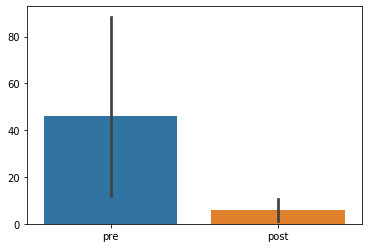

In [435]:
plt.figure()
sb.barplot(data = fishSummary, x = 'id', y = 'ca')

In [436]:
strugTrig_pre

array([ 46.70614759,  15.65184407, 149.68146959,  52.4522218 ,
        -1.68002203,  13.75665928])

In [437]:
strugTrig_post

array([ 0.09647833, -0.07981807,  0.26496101, 15.10689206,  6.72518801,
       12.38182883])

In [439]:
np.savetxt(r'Z:\Marc\motorclamp_post_trace.csv',fishStrugAvg_post.T,delimiter = ",")
np.savetxt(r'Z:\Marc\motorclamp_post_mag.csv',strugTrig_post,delimiter = ",")